In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gdown

# Replace FILE_ID with the actual ID of your file from Google Drive
file_id = '1SQnUPcdqStHvewQtQLHi5QhmmvOZw_jI' #import the dataset zip uploaded in my google drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'dataset.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1SQnUPcdqStHvewQtQLHi5QhmmvOZw_jI
From (redirected): https://drive.google.com/uc?id=1SQnUPcdqStHvewQtQLHi5QhmmvOZw_jI&confirm=t&uuid=d2269fd1-81a2-4898-80f3-74b5fe6e0db5
To: /content/dataset.zip
100%|██████████| 191M/191M [00:04<00:00, 40.7MB/s]


'dataset.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset') #unzip the dataset

In [ ]:
import pickle

with open('dataset/input_data.pkl', 'rb') as f:
    data = pickle.load(f)



imgs = data['imgs']
masks = data['masks']

print( imgs.shape)
print(masks.shape)

(1305, 256, 256, 3)
(1305, 256, 256, 1)


In [ ]:
input_dir = imgs
target_dir = masks
img_size = (128, 128)
num_classes = 3 # the three pixels in the trimap mask
batch_size = 32

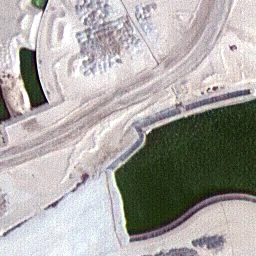

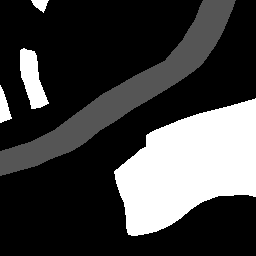

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


# Display the first image in the dataset
first_image = imgs[9]  # Access the first image

# Check if the image needs to be converted to uint8 (common for display)
#first_image = first_image.astype('uint8')

# Display using PIL
img = Image.fromarray(first_image)
display(img)  # Or use `display(img)` in Jupyter Notebook


# Convert to PIL image and apply autocontrast
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

# Ensure the mask is 2D by squeezing any singleton dimensions
first_mask = masks[9].squeeze().astype('uint8')  # Ensure the mask is 2D and in uint8 format

# Convert to PIL image and apply autocontrast
mask_img = Image.fromarray(first_mask)
mask_img_autocontrast = ImageOps.autocontrast(mask_img)

# Display the autocontrasted mask
display(mask_img_autocontrast)


In [ ]:
import tensorflow as tf

# Assuming you have already loaded your data
# imgs = data['imgs']  # Input images
# masks = data['masks']  # Target masks



# Create a TensorFlow dataset
def get_tf_dataset(images, masks, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.batch(batch_size)
    return dataset

# Set your batch size

dataset = get_tf_dataset(imgs, masks, batch_size)

# Example: Iterate over the dataset and print shapes of batches
for img_batch, mask_batch in dataset.take(1):
    print("Image batch shape:", img_batch.shape)
    print("Mask batch shape:", mask_batch.shape)

Image batch shape: (32, 256, 256, 3)
Mask batch shape: (32, 256, 256, 1)


In [ ]:
import random
from sklearn.model_selection import train_test_split
train_size = 0.8  # 80% for training
val_size = 0.1    # 10% for validation
test_size = 0.1   # 10% for testing

# First, split off the test set
X_train, X_test, y_train, y_test = train_test_split(
    imgs, masks, test_size=test_size, random_state=42
)

# Then, split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_size/(1-test_size), random_state=42
)

# Check the shapes of the splits
print("Training images shape:", X_train.shape)
print("Training masks shape:", y_train.shape)
print("Validation images shape:", X_val.shape)
print("Validation masks shape:", y_val.shape)
print("Testing images shape:", X_test.shape)
print("Testing masks shape:", y_test.shape)

def create_tf_dataset(images, masks, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.batch(batch_size)
    return dataset

# Create TensorFlow datasets
batch_size = 32
train_dataset = create_tf_dataset(X_train, y_train, batch_size)
val_dataset = create_tf_dataset(X_val, y_val, batch_size)
test_dataset = create_tf_dataset(X_test, y_test, batch_size)


Training images shape: (1043, 256, 256, 3)
Training masks shape: (1043, 256, 256, 1)
Validation images shape: (131, 256, 256, 3)
Validation masks shape: (131, 256, 256, 1)
Testing images shape: (131, 256, 256, 3)
Testing masks shape: (131, 256, 256, 1)


In [ ]:
def pixel_accuracy(y_true, y_pred):
    # Convert both to same type (float32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Round predictions to nearest integer
    y_pred_rounded = tf.round(y_pred)

    # Clip values to ensure they're in [0, 5] range
    y_pred_clipped = tf.clip_by_value(y_pred_rounded, 0, 5)

    # Compare predictions with ground truth
    correct_pixels = tf.cast(tf.equal(y_true, y_pred_clipped), tf.float32)

    # Calculate accuracy
    return tf.reduce_mean(correct_pixels)

In [ ]:
import keras
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from keras.models import Model, load_model
from keras.layers import Input, Lambda, Dropout, Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K



def custom_sigmoid(x):

    return keras.activations.sigmoid(x)*5

filters = [8, 12, 16, 20, 24]
i = 0
## add a third dimension of value 3. We have RGB images
inputs =  Input(shape=(256, 256, 3))
#print(inputs.shape)
#s = Rescaling(1./255)(inputs)
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)
i+=1
c2 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)
i += 1
c3 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)
i += 1
c4 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
i += 1
c5 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c5)
i -= 1
### HERE ENDS ENCODER
u6 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c6)
i -= 1
u7 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c7)
i -= 1
u8 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c8)
i -= 1
u9 = Conv2DTranspose(filters[i], (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(filters[i], (3, 3), activation='elu', kernel_initializer='he_normal',
            padding='same') (c9)

# Add a per-pixel classification layer
outputs = Conv2D(1, (1, 1), activation=custom_sigmoid)(c9)

model = Model(inputs=[inputs], outputs=[outputs])
lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=[ pixel_accuracy])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 256, 256, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 256, 256, 8)    │            224 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 256, 256, 8)    │              0 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 256, 256, 8)    │            584 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 8)    │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 128, 128, 12)   │            876 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 128, 128, 12)   │              0 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 128, 128, 12)   │          1,308 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 12)     │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 64, 64, 16)     │          1,744 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 64, 64, 16)     │              0 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 64, 64, 16)     │          2,320 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 16)     │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 32, 32, 20)     │          2,900 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 32, 32, 20)     │              0 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 32, 32, 20)     │          3,620 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11     

 Total params: 50,985 (199.16 KB)

 Trainable params: 50,985 (199.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filepath = "model.keras"



#earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                             save_best_only=True, mode='min')

callbacks_list = [checkpoint]

epochs = 100
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks_list,
    verbose=2,
)

Epoch 1/100
33/33 - 4s - 118ms/step - loss: 0.4214 - pixel_accuracy: 0.7612 - val_loss: 0.4317 - val_pixel_accuracy: 0.7140
Epoch 2/100
33/33 - 4s - 112ms/step - loss: 0.4178 - pixel_accuracy: 0.7634 - val_loss: 0.4778 - val_pixel_accuracy: 0.7065
Epoch 3/100
33/33 - 4s - 114ms/step - loss: 0.4181 - pixel_accuracy: 0.7633 - val_loss: 0.4457 - val_pixel_accuracy: 0.7146
Epoch 4/100
33/33 - 4s - 115ms/step - loss: 0.4177 - pixel_accuracy: 0.7629 - val_loss: 0.4437 - val_pixel_accuracy: 0.7179
Epoch 5/100
33/33 - 4s - 114ms/step - loss: 0.4152 - pixel_accuracy: 0.7649 - val_loss: 0.4682 - val_pixel_accuracy: 0.7103
Epoch 6/100
33/33 - 5s - 156ms/step - loss: 0.4124 - pixel_accuracy: 0.7682 - val_loss: 0.4651 - val_pixel_accuracy: 0.7153
Epoch 7/100
33/33 - 5s - 156ms/step - loss: 0.4140 - pixel_accuracy: 0.7666 - val_loss: 0.4398 - val_pixel_accuracy: 0.7178
Epoch 8/100
33/33 - 5s - 152ms/step - loss: 0.4099 - pixel_accuracy: 0.7685 - val_loss: 0.4615 - val_pixel_accuracy: 0.7112
Epoch 9/

In [ ]:
# use the best model epoch
model.load_weights('model.keras')

test_preds = model.predict(test_dataset)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


In [ ]:
test_preds[0].shape

(256, 256, 1)

In [ ]:
model.load_weights('model.keras')

# Get one batch from test dataset
for images, masks in test_dataset.take(5):
    # Get predictions for this batch
    predictions = model.predict(images)

    # Take first image from the batch
    original_image = images[0]
    original_mask = masks[0]
    predicted_mask = predictions[0]

    # Convert to displayable images
    original_img = tf.keras.utils.array_to_img(original_image)
    mask_img = tf.keras.utils.array_to_img(original_mask)
    pred_img = tf.keras.utils.array_to_img(predicted_mask)

    # Display all three
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(mask_img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_img)
    plt.axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.